<h2 align=center>Sentiment Analysis Model for IMDB Movies reviews Using Word2Vec and LSTM

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import nltk
import string
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading Data 

In [13]:
df = pd.read_csv("/content/drive/MyDrive/Sentiment-Analysis-Model/IMDB_reviews.csv", 
                 encoding='utf-8')
df.head(10)

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


## Data Preprocessing

In [29]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

reviews_lines = list() # Initialize an empty list
lines = df["review"].values.tolist() # get list of reviews from review column in dataset

#Loop through each of the review in the lines list
for line in lines:
  tokens=word_tokenize(line)  #tokenize each review
  #normalization - loop through each word and lowercase them
  tokens=[word.lower() for word in tokens]
  #remove punctuation from the string
  table=str.maketrans('','',string.punctuation)
  stripped=[w.translate(table) for w in tokens]
  #remove all the tokens which are not alphhabetic
  words=[word for word in stripped if word.isalpha()]
  #filter out the stop words
  stop_words=set(stopwords.words('english')) #set so as duplicates are deleted
  words=[w for w in words if not w in stop_words] #filter out stopwrods from words as well
  #fill all these words to our review_lines list
  reviews_lines.append(words)

In [30]:
EMBEDDING_DIM=100
#define the Word2Vec model
model=Word2Vec(sentences=reviews_lines, size=EMBEDDING_DIM, window=5, min_count=1)
#Check the vocabulary size
words=list(model.wv.vocab)
print("Vocabulary Size: %d" % len(words))

Vocabulary Size: 134156


Lets test our Word2Vec Model to see how it performs using utility functions provided in Gensim

In [31]:
model.wv.most_similar("director")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('filmmaker', 0.7517985105514526),
 ('screenwriter', 0.6736822128295898),
 ('writerdirector', 0.6689409017562866),
 ('directors', 0.6473158001899719),
 ('writer', 0.618447482585907),
 ('altman', 0.6026250123977661),
 ('vipul', 0.6006599068641663),
 ('editor', 0.599696159362793),
 ('directorial', 0.5992975831031799),
 ('harlin', 0.5977598428726196)]

Let’s see the result of semantically reasonable word vectors (actress - actor + heroine)


In [32]:
model.wv.most_similar(positive=["actress", "heroine"], negative=["actor"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('sexually', 0.7284572124481201),
 ('nurse', 0.7118648290634155),
 ('stepmother', 0.7097549438476562),
 ('protagonist', 0.6994047164916992),
 ('vulnerable', 0.6917494535446167),
 ('attraction', 0.6912575960159302),
 ('housewife', 0.6845434308052063),
 ('blonde', 0.673975944519043),
 ('seductive', 0.6690043807029724),
 ('jealousy', 0.6687324047088623)]

**Odd One out** - Finding the odd word out of the given list of words

In [33]:
print(model.wv.doesnt_match("film movie theatre tea".split()))

tea


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Save model in ASCII (word2vec) format

In [34]:
filename="imdb_embedding_word2vec.txt"
model.wv.save_word2vec_format(filename, binary=False)

## Load the embeddings from the file into a dictionary

In [35]:
import  os
embeddings_index={}
f = open("imdb_embedding_word2vec.txt", encoding='utf-8')
for line in f:
  values=line.split()
  word=values[0]
  coefs=np.asarray(values[1:])
  embeddings_index[word]=coefs

f.close()

In [36]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import numpy as np

VALIDATION_SPLIT = 0.2

tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(reviews_lines)
sequences = tokenizer_obj.texts_to_sequences(reviews_lines)

max_length=100
word_index=tokenizer_obj.word_index

review_pad=pad_sequences(sequences, maxlen=max_length)
sentiment=df["sentiment"].values

print(review_pad.shape)
print(sentiment.shape)
                                  

(50000, 100)
(50000,)


In [41]:
indices=np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad=review_pad[indices]
sentiment=sentiment[indices]
num_validation_samples=int(VALIDATION_SPLIT*review_pad.shape[0])

X_val_pad=review_pad[:num_validation_samples]
y_val=sentiment[:num_validation_samples]
X_train_pad=review_pad[num_validation_samples:]
y_train=sentiment[num_validation_samples:]

## Splitting Train data further into Train & Test Sets

In [42]:
TEST_SPLIT = 0.1

num_test_samples = int(TEST_SPLIT * X_train_pad.shape[0])

X_test_pad = X_train_pad[:num_test_samples]
y_test = y_train[:num_test_samples]
X_train_pad = X_train_pad[num_test_samples:]
y_train = y_train[num_test_samples:]

In [43]:
print(X_train_pad.shape)
print(y_train.shape)

print(X_val_pad.shape)
print(y_val.shape)

print(X_test_pad.shape)
print(y_test.shape)

(36000, 100)
(36000,)
(10000, 100)
(10000,)
(4000, 100)
(4000,)


## Creating an Embedding Matrix

In [46]:
EMBEDDING_DIM=100
num_words = len(word_index)+1
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))

for word, i in word_index.items():
  if i>num_words:
    continue
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector

## Training 

In [53]:
#Model Definition

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

model=Sequential()
embedding_layer=Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix),
                          input_length=max_length, trainable=False)
model.add(embedding_layer)
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Summary of the built model..')
print(model.summary())

Summary of the built model..
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          13415700  
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,432,757
Trainable params: 17,057
Non-trainable params: 13,415,700
_________________________________________________________________
None


## Training the Model

In [54]:
history=model.fit(X_train_pad,y_train,batch_size=128, epochs=10,
                  validation_data=(X_val_pad,y_val), verbose=2)

Epoch 1/10
282/282 - 88s - loss: 0.4776 - accuracy: 0.7717 - val_loss: 0.3883 - val_accuracy: 0.8257
Epoch 2/10
282/282 - 88s - loss: 0.3787 - accuracy: 0.8337 - val_loss: 0.3812 - val_accuracy: 0.8307
Epoch 3/10
282/282 - 88s - loss: 0.3489 - accuracy: 0.8459 - val_loss: 0.3324 - val_accuracy: 0.8529
Epoch 4/10
282/282 - 92s - loss: 0.3313 - accuracy: 0.8526 - val_loss: 0.3174 - val_accuracy: 0.8588
Epoch 5/10
282/282 - 91s - loss: 0.3156 - accuracy: 0.8639 - val_loss: 0.3156 - val_accuracy: 0.8616
Epoch 6/10
282/282 - 91s - loss: 0.3098 - accuracy: 0.8641 - val_loss: 0.3230 - val_accuracy: 0.8610
Epoch 7/10
282/282 - 92s - loss: 0.3005 - accuracy: 0.8706 - val_loss: 0.3146 - val_accuracy: 0.8648
Epoch 8/10
282/282 - 91s - loss: 0.2941 - accuracy: 0.8730 - val_loss: 0.3012 - val_accuracy: 0.8682
Epoch 9/10
282/282 - 91s - loss: 0.2894 - accuracy: 0.8768 - val_loss: 0.3044 - val_accuracy: 0.8681
Epoch 10/10
282/282 - 92s - loss: 0.2843 - accuracy: 0.8781 - val_loss: 0.2942 - val_accura

## Evaluating the Model on Test Set


In [60]:
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)
print("Test Score:", score)
print("Test Accuracy:", acc)

32/32 [==============================] - 1s 28ms/step - loss: 0.2868 - accuracy: 0.8798
Test Score: 0.28682342171669006
Test Accuracy: 0.8797500133514404


## Plotting the Accuracy and Loss 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


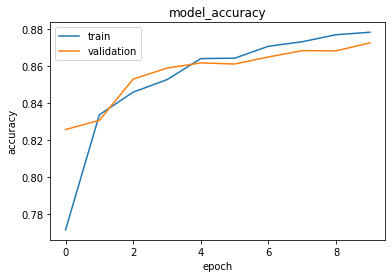

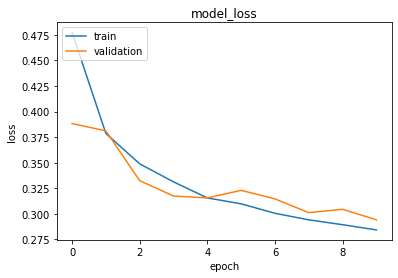

In [62]:
print(history.history.keys())

#accuracy plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model_accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train","validation"], loc="upper left")
plt.show()

#loss plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model_loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","validation"], loc="upper left")
plt.show()

## Testing the Model on Sample data


In [68]:
test_sample_1 = "What a fantastic Movie it was! Wow!!"
test_sample_2 = "What a crap Movie it was! total waste of time and money!!"

test_samples = [test_sample_1, test_sample_2]

test_samples_tokens = tokenizer_obj.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=100)

#model prediction
model.predict(test_samples_tokens_pad)

array([[0.9254662 ],
       [0.00304869]], dtype=float32)